Declarations - always run this before proceeding to diff sections below

Start: start byte "P", 4 bytes each data (1 byte for sign, 3 hex bytes for mag), end byte "V"

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import time
import serial
from scipy.signal import find_peaks

# Variables
heart_amplitude = 0.5
heart_frequency = 120 / 60  # Hz
lung_amplitude = 0.5
lung_frequency = 15 / 60   # Hz
lead_screw_lead = 8
steps_per_revolution = 200
wave_period = 1 / lung_frequency

# Time vectors
t_fine = np.arange(0, wave_period, 0.01)

def generate_motion(t, heart_amplitude, heart_frequency, lung_amplitude, lung_frequency):
    heart_motion = heart_amplitude * np.sin(2 * np.pi * heart_frequency * t)
    lung_motion = lung_amplitude * np.sin(2 * np.pi * lung_frequency * t)
    combined_motion = heart_motion + lung_motion
    return heart_motion, lung_motion, combined_motion

def encode_motor_instructions(steps):
    data = ['P']  # Start byte 'P'
    for step in steps:
        sign = '1' if step >= 0 else '0'
        magnitude = f'{abs(step):03X}'    # mag in 3 hex bytes, sign in 1 byte, total 4 bytes per datapoint
        data.append(sign)                    
        data.append(magnitude)
    data.append('V')                      # End byte 'V'
    return ''.join(data).encode('utf-8')

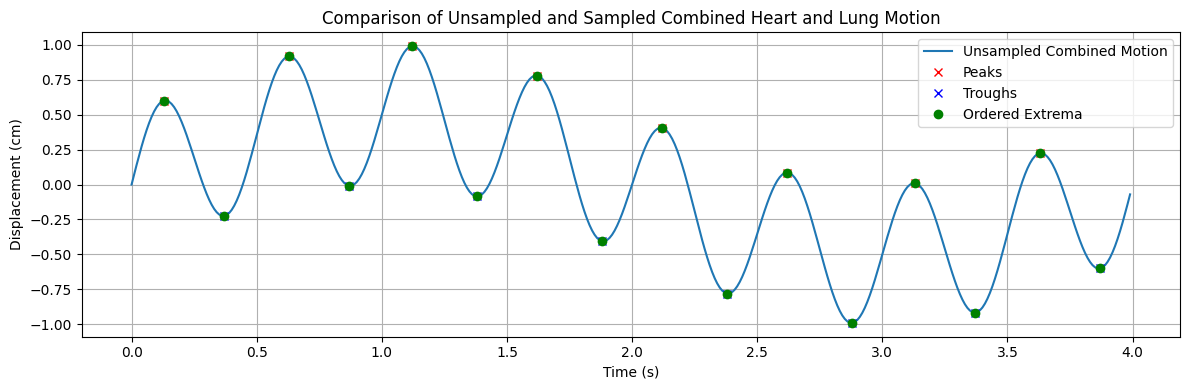

4011
Non-encoded Motor Steps: [-206  285 -232  250 -269  216 -296  203 -296  216 -269  250 -232  285
 -206  300]
Encoded Motor Instructions: b'P00CE111D00E810FA010D10D8012810CB012810D8010D10FA00E8111D00CE112CV'


In [23]:
heart_motion_fine, lung_motion_fine, combined_motion_fine = generate_motion(t_fine, heart_amplitude, heart_frequency, lung_amplitude, lung_frequency)

peaks, _ = find_peaks(combined_motion_fine)
troughs, _ = find_peaks(-combined_motion_fine)

extrema_indices = np.sort(np.concatenate((peaks, troughs)))
extrema_values = combined_motion_fine[extrema_indices]
extrema_values_mm = extrema_values * 10  # in mm

# Plot
plt.figure(figsize=(12, 4))
plt.plot(t_fine, combined_motion_fine, label='Unsampled Combined Motion', linestyle='-')
plt.plot(t_fine[peaks], combined_motion_fine[peaks], 'rx', label='Peaks')
plt.plot(t_fine[troughs], combined_motion_fine[troughs], 'bx', label='Troughs')
plt.plot(t_fine[extrema_indices], combined_motion_fine[extrema_indices], 'go', label='Ordered Extrema')
plt.title('Comparison of Unsampled and Sampled Combined Heart and Lung Motion')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (cm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

displacements_mm = np.diff(extrema_values_mm)
steps_per_mm = steps_per_revolution / lead_screw_lead 
motor_steps = np.round(displacements_mm * steps_per_mm).astype(int)

# Add return step to complete iteration
return_step = -np.round((extrema_values_mm[-1] - extrema_values_mm[0]) * steps_per_mm).astype(int)
motor_steps = np.append(motor_steps, return_step)

motor_instructions = encode_motor_instructions(motor_steps)

total_steps = np.sum(np.abs(motor_steps))
print(total_steps)
print(f'Non-encoded Motor Steps: {motor_steps}')
print(f'Encoded Motor Instructions: {motor_instructions}')

In [24]:
ser = serial.Serial('COM4', 9600, timeout=1)
time.sleep(2) 
ser.flush()
ser.flushInput()
ser.write(motor_instructions)

while True:
    if ser.in_waiting > 0:
        line = ser.readline().decode('utf-8').rstrip()
        if line == "Y":
            break
        print(line)

# Close serial connection
ser.close()
print("End")

11288
End
